### Test 2

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import csv

truth = []
with open('train.truth.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        truth.append(row)

In [16]:
import glob
import cv2

rgb_order = [2, 1, 0]

im_test0 = []
pred = [['fn', 'label']]
for file in glob.glob("test/*.jpg"):
    pred.append([file[5:], ''])
    im_test0.append(cv2.imread(file)[:, :, rgb_order])
    
im_test = np.zeros((len(im_test0), 64, 64, 3), dtype=np.uint8)
for i in range(len(im_test0)):
    im_test[i, :, :, :] = im_test0[i]


im_train = np.zeros((len(truth), 64, 64, 3), dtype=np.uint8)
labels = np.zeros((len(truth), 4), dtype=np.float32)
label_dict = {'upright': 0, 'rotated_left': 1, 'rotated_right': 2, 'upside_down':3}
for i, elem in enumerate(truth[1:]):
    file_name = 'train/' + elem[0]
    im_train[i, :, :, :] = cv2.imread(file_name)[:, :, rgb_order]
    j = label_dict[elem[1]]
    labels[i, j] = 1 


In [17]:
im_train = im_train.astype('float32')
im_test = im_test.astype('float32')
im_train /= 255
im_test /= 255

In [18]:
im_train.shape

(48897, 64, 64, 3)

In [19]:
labels.shape

(48897, 4)

In [20]:
# The data, split between train and test sets:
from sklearn.model_selection import train_test_split

im_train = im_train[0:10000, :, :, :]
labels = labels[0:10000, :]
x_train, x_test, y_train, y_test = train_test_split(im_train, labels, test_size=0.2)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8000, 64, 64, 3)
8000 train samples
2000 test samples


In [8]:

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 4#10
epochs = 4#100


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
#opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(learning_rate=1e-4)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)


# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/4
250/250 [==============================] - 71s 285ms/step - loss: 0.9989 - accuracy: 0.5748 - val_loss: 0.4747 - val_accuracy: 0.8405
Epoch 2/4
250/250 [==============================] - 71s 283ms/step - loss: 0.4703 - accuracy: 0.8271 - val_loss: 0.3491 - val_accuracy: 0.8650
Epoch 3/4
250/250 [==============================] - 70s 282ms/step - loss: 0.3548 - accuracy: 0.8656 - val_loss: 0.2958 - val_accuracy: 0.8905
Epoch 4/4
63/63 [==============================] - 3s 52ms/step - loss: 0.2490 - accuracy: 0.9125
Test loss: 0.24903713166713715
Test accuracy: 0.9125000238418579


In [9]:
#This function saves the model to the disk.
def save_model(model, name):
    #Save the model
    #serialize model to JSON
    model_digit_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json_file.write(model_digit_json)
    #serialize weights to HDF5
    model.save_weights(name+".h5")
    print("Saved model to disk")

save_model(model, 'DS_model')

Saved model to disk


### Predict on test images and save csv file

In [24]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop, Adam
#This function loads the model.
def load_model(name):
    #load json and create model
    json_file = open(name+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    #load weights into new model
    loaded_model.load_weights(name+".h5")
    print("Loaded model from disk")
    return loaded_model

model = load_model('DS_model')
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

Loaded model from disk


In [8]:
# Predict on Test images
model_predict = model.predict(im_test)

for i, elem in enumerate(pred[1:]):
    argmax = np.argmax(model_predict[i, :])
    if argmax == 0:
        elem[1] = 'upright'
    elif argmax == 1:
        elem[1] = 'rotated_left'
    elif argmax == 2:
        elem[1] = 'rotated_right'
    else:
        elem[1] = 'upside_down'
        
pred[0:5]

[['fn', 'label'],
 ['93-23730893_1988-05-18_2012.jpg', 'rotated_left'],
 ['99-667599_1938-06-05_1963.jpg', 'upright'],
 ['99-45240299_1991-05-22_2014.jpg', 'rotated_right'],
 ['92-292592_1967-02-19_2014.jpg', 'rotated_right']]

In [11]:
with open('test.preds.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for elem in pred:
        writer.writerow(elem)

### Correct images

In [9]:
def rotate_fig(fig, label):
    if label == 1:
        for i in range(3):
            fig[:, :, i] = np.transpose(fig[:, :, i])
    elif label == 2:
        for i in range(3):
            fig[:, :, i] = np.transpose(fig[:, :, i])
            fig[:, :, i] = np.flipud(fig[:, :, i])
    elif label == 3:
        for i in range(3):
            fig[:, :, i] = np.flipud(fig[:, :, i])
    
    return fig

In [14]:
directory = 'corrected_images'
if not os.path.isdir(directory):
    os.mkdir(directory)

corr_im = im_test.copy() 
prediction = model.predict(corr_im[:, :, :, :])

#loop over figures
for i in range(prediction.shape[0]):
    f = im_train[i, :, :, :].copy()
    argmax = np.argmax(prediction[i, :])
    corr_im[i, :, :, :] = rotate_fig(f, argmax)
    
# Save numpy array.
np.save('corrected_figs_array', corr_im)

KeyboardInterrupt: 

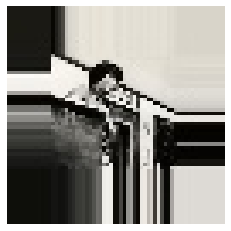

In [15]:
#generate figure
fig, ax = plt.subplots()        
ax.axis('off')

for i in range(100)#range(prediction.shape[0]):    
    #save figure
    ax.imshow(corr_im[i, :, :, :], interpolation=None)
    file_name = directory + '/' + (pred[i + 1][0])[0:-4]
    fig.savefig(file_name)

250/250 [==============================] - 10s 41ms/step - loss: 0.2194 - accuracy: 0.9281
Test loss: 0.21942611038684845
Test accuracy: 0.9281250238418579
